In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import autograd
import torch.nn.functional as F

import csv

NUM_RAND_VER = 25000

images = np.load("images.npy")
labels = np.load("labels.npy")
test_data = np.load("test_images.npy")

ver_entries = np.random.choice(labels.shape[0], size=NUM_RAND_VER, replace=False)
images_flip_vertical = images[ver_entries].copy()

#for index, image_hori in enumerate(images_flip_horizontal):
#    for i in range(0, len(test_data[0])-1):
#        for j in range(0,12):
#            image_hori[i][j] = images[index][i][25-j]
#        for k in range(0,12):
#            image_hori[i][k+13] = images[index][i][12-k]

for index_vert, image_vert in enumerate(images_flip_vertical):
    for i in range(0, len(test_data[0][0])):
        for j in range(0,13):
            image_vert[j][i] = images[index_vert][25-j][i]
        for k in range(0,13):
            image_vert[k+13][i] = images[index_vert][12-k][i]

images_full = np.concatenate((images, images_flip_vertical), axis=0)
labels_full = np.concatenate((labels, labels[ver_entries]), axis=0)

images_full = images
labels_full = labels

val_entries = np.random.choice(labels_full.shape[0], size=int(len(labels_full)*0.01), replace=False)



flat_test_data = np.zeros((len(test_data), len(test_data[0])*len(test_data[0][0])))
for j in range(0, len(test_data)-1):
    flat_test_data[j] = test_data[j].flatten()

flat_images = np.zeros((len(images_full),len(images_full[0])*len(images_full[0][0])))
for i in range(0, len(images_full)-1):
    flat_images[i] = images_full[i].flatten()

not_val = [x for x in range(len(flat_images)) if x not in val_entries]

train_images = flat_images[not_val]
train_labels = labels_full[not_val]
val_images = flat_images[val_entries]
val_labels = labels_full[val_entries]

MEAN = np.mean(train_images)
STD = np.std(train_images, axis=0)
    
val_images -= np.mean(train_images)
flat_test_data -= np.mean(train_images)
train_images -= np.mean(train_images)
val_images /= np.std(train_images, axis=0)
flat_test_data /= np.std(train_images, axis=0)
train_images /=np.std(train_images, axis=0)


HEIGHT = 26
WIDTH = 26
NUM_CLASSES = 5
D_H = 100
NUM_OPT_STEPS = 2000

In [2]:
class ConvNN1(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, 5)
        self.conv2 = torch.nn.Conv2d(8, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.conv4 = torch.nn.Conv2d(128, 128*8, 2)
        self.fc1 = torch.nn.Linear(128*8, 400)
        self.fc2 = torch.nn.Linear(400, 100)
        self.fc3 = torch.nn.Linear(100, 5)
        self.conv2_drop = torch.nn.Dropout2d(p=0.25)
        
    def forward(self, x):
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=3))
        x = F.relu(self.conv2_drop(self.conv3(x)))
        x = F.relu(self.conv2_drop(self.conv4(x)))
        
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        
        x = x.view(-1, 128*8)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    

In [3]:
class ConvNN2(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, 5)
        self.conv2 = torch.nn.Conv2d(8, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.conv4 = torch.nn.Conv2d(128, 128*4, 2)
        self.fc1 = torch.nn.Linear(128*4, 200)
        self.fc2 = torch.nn.Linear(200, 50)
        self.fc3 = torch.nn.Linear(50, 5)
        self.conv2_drop = torch.nn.Dropout2d(p=0.25)
        
    def forward(self, x):
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        
        x = F.relu(self.conv2_drop(self.conv1(x)))
        x = F.relu(F.avg_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=3))
        x = F.relu(self.conv2_drop(self.conv3(x)))
        x = F.relu(self.conv2_drop(self.conv4(x)))
        
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        
        x = x.view(-1, 128*4)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x

In [4]:
model = ConvNN1()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

In [5]:
def train(batch_size):
    i = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    x = torch.from_numpy(train_images[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.int))
    del i
    y_hat_ = model.forward(x)
    loss = F.cross_entropy(y_hat_, y)
    del y
    del x
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [6]:
def accuracy(y, y_hat):
    return (y == y_hat).astype(np.float).mean()

In [7]:
def approx_train_accuracy():
    i = np.random.choice(train_images.shape[0], size=1000, replace=False)
    x = torch.from_numpy(train_images[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.int))
    y_hat = torch.from_numpy(labels_full[i].astype(np.int))
    for spot, val in enumerate(x):
        y_hat[spot] = torch.max(model(val), 1)[1]
    del x
    return accuracy(y.numpy(), y_hat.numpy())

In [8]:
def val_accuracy():
    x = torch.from_numpy(val_images.astype(np.float32))
    y = torch.from_numpy(val_labels.astype(np.int))
    y_hat = torch.from_numpy(val_labels.astype(np.int))
    for spot, val in enumerate(x):
        y_hat[spot] = torch.max(model(val), 1)[1]
    del x
    return accuracy(y.numpy(), y_hat.numpy())

In [9]:
train_accs, val_accs, steps = [], [], []
last_val = 0.0
last_val2 = -1.0
flag = True
for i in range(4001):
    model.train()
    train(200)
    if i % 100 == 0:
        model.eval()
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        steps.append(i)
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
        if val_accs[-1] >= 0.935 and flag:
            optimizer = torch.optim.SGD(model.parameters(), lr=5e-6, weight_decay=0)
            flag = False

     0  0.21  0.21
   100  0.76  0.77
   200  0.88  0.90
   300  0.89  0.89
   400  0.92  0.92
   500  0.93  0.92
   600  0.93  0.92
   700  0.94  0.94
   800  0.93  0.94
   900  0.95  0.94
  1000  0.93  0.94
  1100  0.93  0.94
  1200  0.92  0.94
  1300  0.93  0.94
  1400  0.92  0.94
  1500  0.93  0.94
  1600  0.94  0.94
  1700  0.93  0.94
  1800  0.92  0.94
  1900  0.92  0.94
  2000  0.92  0.94
  2100  0.93  0.94
  2200  0.93  0.94
  2300  0.93  0.94
  2400  0.93  0.94
  2500  0.93  0.94
  2600  0.94  0.94
  2700  0.94  0.94
  2800  0.93  0.94
  2900  0.94  0.94
  3000  0.93  0.94
  3100  0.93  0.94
  3200  0.94  0.94
  3300  0.93  0.94
  3400  0.92  0.94
  3500  0.92  0.94
  3600  0.92  0.94
  3700  0.92  0.94
  3800  0.93  0.94
  3900  0.93  0.94
  4000  0.93  0.94


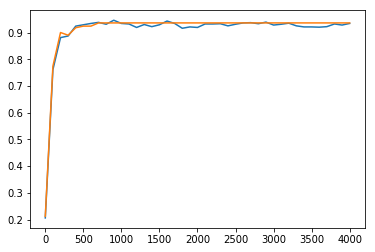

In [10]:
plt.plot(steps, train_accs)
plt.plot(steps, val_accs)

In [17]:
with open('erothma6.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',')
    csv_writer.writerow(["id", "label"])
    data_for_test = torch.from_numpy(flat_test_data.astype(np.float32))
    model.eval()
    for numb, test_val in enumerate(data_for_test):
        csv_writer.writerow([numb, torch.max(model(test_val), 1)[1].numpy()[0]])

In [71]:
model = ConvNN2()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
train_accs, val_accs, steps = [], [], []
for i in range(3600):
    train(800)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        steps.append(i)
        print("%6d %5.2f %5.3f" % (i, train_accs[-1], val_accs[-1]))
        if i == 3000:
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

     0  0.22 0.204
   100  0.64 0.658
   200  0.76 0.756
   300  0.79 0.778
   400  0.83 0.836
   500  0.85 0.834
   600  0.89 0.858
   700  0.88 0.850
   800  0.90 0.862
   900  0.88 0.842
  1000  0.89 0.880
  1100  0.90 0.870
  1200  0.88 0.852
  1300  0.90 0.882
  1400  0.91 0.884
  1500  0.90 0.888
  1600  0.93 0.874
  1700  0.90 0.884
  1800  0.91 0.888
  1900  0.93 0.888
  2000  0.93 0.896
  2100  0.92 0.888
  2200  0.91 0.888
  2300  0.91 0.884
  2400  0.92 0.886
  2500  0.92 0.892
  2600  0.92 0.904
  2700  0.92 0.898
  2800  0.95 0.900
  2900  0.92 0.908
  3000  0.92 0.898
  3100  0.93 0.906
  3200  0.93 0.904
  3300  0.94 0.910
  3400  0.95 0.904
  3500  0.94 0.926


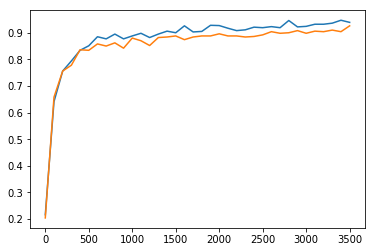

In [72]:
plt.plot(steps, train_accs)
plt.plot(steps, val_accs)

In [13]:
model = ConvNN1()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
train_accs, val_accs, steps = [], [], []
for i in range(3000):
    train(800)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        steps.append(i)
        print("%6d %5.2f %5.3f" % (i, train_accs[-1], val_accs[-1]))

     0  0.20 0.226
   100  0.83 0.810
   200  0.89 0.858
   300  0.89 0.886
   400  0.91 0.890
   500  0.93 0.914
   600  0.93 0.898
   700  0.93 0.936
   800  0.94 0.916
   900  0.95 0.930
  1000  0.95 0.918
  1100  0.95 0.910
  1200  0.95 0.922
  1300  0.96 0.930
  1400  0.96 0.928
  1500  0.95 0.932
  1600  0.96 0.922
  1700  0.95 0.926
  1800  0.97 0.930
  1900  0.96 0.922
  2000  0.96 0.934
  2100  0.97 0.914
  2200  0.96 0.936
  2300  0.97 0.918
  2400  0.96 0.932
  2500  0.97 0.928
  2600  0.97 0.926
  2700  0.98 0.922
  2800  0.97 0.924
  2900  0.96 0.934


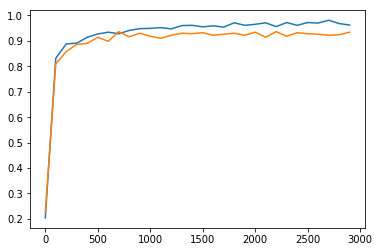

In [14]:
plt.plot(steps, train_accs)
plt.plot(steps, val_accs)

In [73]:
x = torch.from_numpy(val_images.astype(np.float32))
y = torch.from_numpy(val_labels.astype(np.int))
y_hat = torch.from_numpy(val_labels.astype(np.int))
for spot, val in enumerate(x):
    y_hat[spot] = torch.max(model(val), 1)[1]
del x
for spoy, vay in enumerate(y):
    if vay != y_hat[spoy]:
        print(spoy, y_hat[spoy].numpy(), vay.numpy())

13 0 1
20 1 3
69 4 1
78 2 3
100 4 1
111 0 4
114 2 4
120 0 3
125 4 1
143 4 1
152 3 2
155 4 2
158 3 1
173 1 4
195 4 1
196 0 2
198 4 1
209 1 2
214 0 3
233 4 3
236 2 1
239 3 2
244 4 0
273 2 4
276 0 3
286 3 2
292 4 1
322 4 0
325 1 4
327 1 3
329 2 3
330 4 1
331 1 2
338 2 4
350 1 3
364 4 0
366 2 3
406 4 1
409 0 4
428 4 1
432 4 0
443 2 1
468 3 1
472 3 0
481 3 2
483 4 1
488 1 3


In [74]:
print("CORRECTLY CLASSIFIED IMAGES")

CORRECTLY CLASSIFIED IMAGES


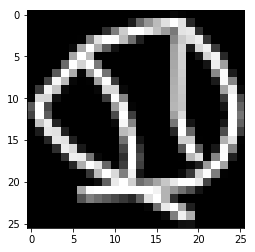

In [76]:
plt.imshow(images[val_entries[0]])
plt.set_cmap("gray")

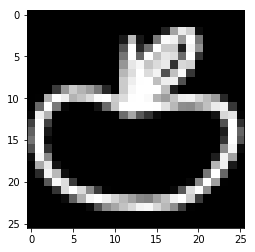

In [77]:
plt.imshow(images[val_entries[1]])
plt.set_cmap("gray")

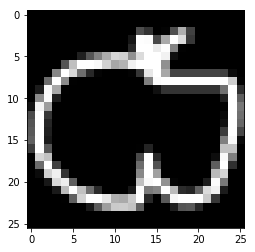

In [78]:
plt.imshow(images[val_entries[2]])
plt.set_cmap("gray")

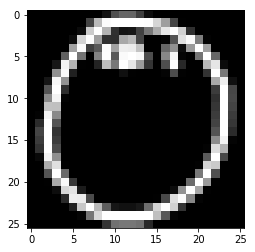

In [79]:
plt.imshow(images[val_entries[3]])
plt.set_cmap("gray")

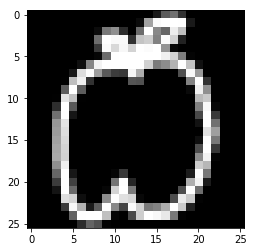

In [80]:
plt.imshow(images[val_entries[4]])
plt.set_cmap("gray")

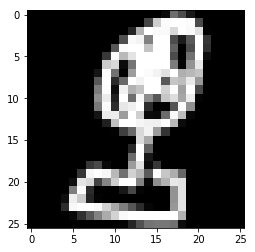

In [81]:
plt.imshow(images[val_entries[5]])
plt.set_cmap("gray")

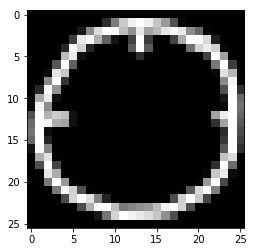

In [82]:
plt.imshow(images[val_entries[6]])
plt.set_cmap("gray")

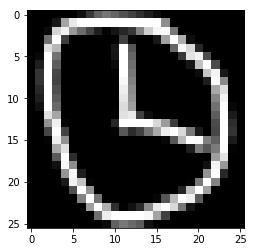

In [83]:
plt.imshow(images[val_entries[7]])
plt.set_cmap("gray")

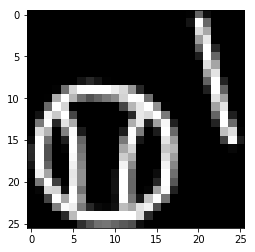

In [84]:
plt.imshow(images[val_entries[8]])
plt.set_cmap("gray")

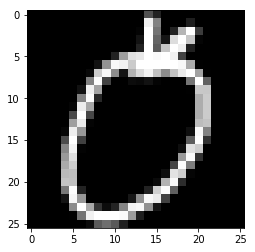

In [85]:
plt.imshow(images[val_entries[9]])
plt.set_cmap("gray")

In [86]:
print("INCORRECTLY CLASSIFIED IMAGES")

INCORRECTLY CLASSIFIED IMAGES


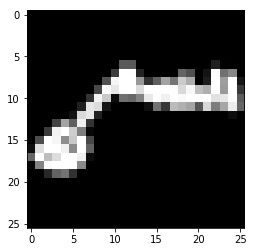

In [87]:
plt.imshow(images[val_entries[13]])
plt.set_cmap("gray")

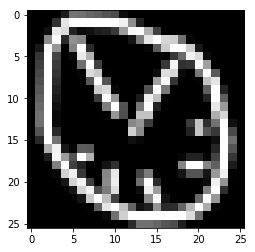

In [88]:
plt.imshow(images[val_entries[20]])
plt.set_cmap("gray")

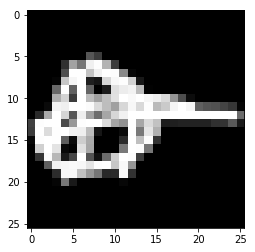

In [89]:
plt.imshow(images[val_entries[69]])
plt.set_cmap("gray")

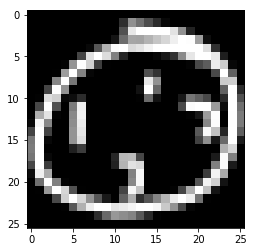

In [90]:
plt.imshow(images[val_entries[78]])
plt.set_cmap("gray")

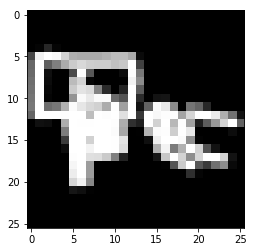

In [91]:
plt.imshow(images[val_entries[100]])
plt.set_cmap("gray")

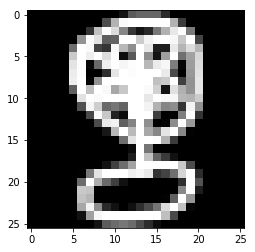

In [92]:
plt.imshow(images[val_entries[110]])
plt.set_cmap("gray")

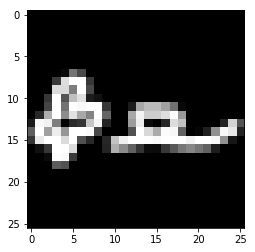

In [93]:
plt.imshow(images[val_entries[114]])
plt.set_cmap("gray")

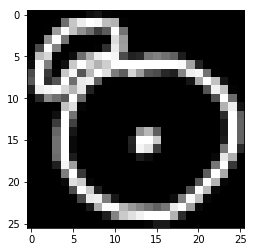

In [94]:
plt.imshow(images[val_entries[120]])
plt.set_cmap("gray")

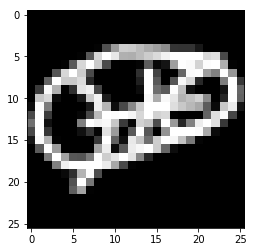

In [95]:
plt.imshow(images[val_entries[125]])
plt.set_cmap("gray")

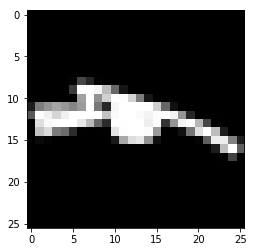

In [96]:
plt.imshow(images[val_entries[143]])
plt.set_cmap("gray")

In [97]:
correct_images = np.zeros((10,26,26))
correct_images[0] = images[val_entries[0]]
correct_images[1] = images[val_entries[1]]
correct_images[2] = images[val_entries[2]]
correct_images[3] = images[val_entries[3]]
correct_images[4] = images[val_entries[4]]
correct_images[5] = images[val_entries[5]]
correct_images[6] = images[val_entries[6]]
correct_images[7] = images[val_entries[7]]
correct_images[8] = images[val_entries[8]]
correct_images[9] = images[val_entries[9]]
torch_images = torch.from_numpy(correct_images)
noise = torch.randn(10,26,26)
gausian_images = torch.add(torch_images.double(), torch.from_numpy(noise.numpy()*26.5).double())
print(labels[val_entries])

[1 0 0 3 0 4 3 3 1 0 1 0 0 1 2 2 1 4 2 2 3 3 2 3 2 3 3 2 4 1 2 1 2 3 1 0 4
 3 2 1 0 3 0 2 1 0 0 1 3 3 2 4 1 0 2 3 1 4 4 3 3 4 2 4 0 0 3 3 1 1 0 0 3 3
 3 2 2 0 3 2 2 4 1 1 4 4 1 1 0 1 1 0 4 2 3 3 4 4 0 0 1 3 3 2 2 0 0 0 3 2 4
 4 0 3 4 0 1 1 0 0 3 1 1 4 0 1 2 4 4 1 3 3 2 0 4 0 0 4 4 0 1 3 4 1 1 2 4 0
 4 1 4 3 2 1 1 2 0 1 1 1 3 0 3 4 2 0 4 2 2 3 3 4 2 4 1 4 4 1 0 2 4 1 3 1 1
 4 2 2 2 0 4 4 4 4 4 1 2 1 1 0 0 1 0 2 4 3 2 0 1 2 1 0 4 1 3 0 1 0 0 0 4 3
 4 3 4 4 0 1 2 1 2 0 0 3 1 3 1 4 4 2 1 2 2 4 0 0 0 1 0 3 2 0 1 0 0 2 3 2 0
 1 3 0 4 4 4 2 3 2 0 0 3 2 3 4 3 2 3 0 4 4 4 2 3 1 0 3 2 0 4 2 3 4 1 0 4 0
 3 2 3 3 0 3 0 2 0 3 2 2 4 3 2 4 2 1 0 3 4 2 4 2 1 4 0 0 0 4 2 3 2 3 1 2 2
 3 1 4 0 0 4 0 2 2 3 4 4 3 4 3 1 1 3 2 4 0 2 1 3 2 3 0 2 0 2 3 0 0 3 4 3 0
 1 3 1 2 1 1 3 2 4 1 0 1 4 0 3 2 3 4 0 1 1 4 4 0 3 4 3 1 3 4 3 4 2 2 1 3 1
 2 4 4 2 3 4 3 2 3 1 1 3 0 1 3 4 2 3 2 1 4 1 1 1 3 0 0 4 4 1 3 1 0 3 2 4 1
 1 4 3 1 3 3 1 0 1 4 4 4 4 3 3 4 4 3 2 0 3 0 0 4 1 2 1 4 0 3 4 1 3 0 4 2 1
 2 0 1 0 3 2 3 3 3 3 1 2 

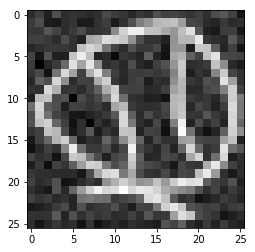

In [98]:
plt.imshow(gausian_images[0])
plt.set_cmap("gray")


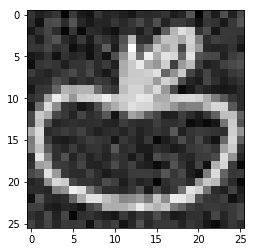

In [99]:
plt.imshow(gausian_images[1])
plt.set_cmap("gray")

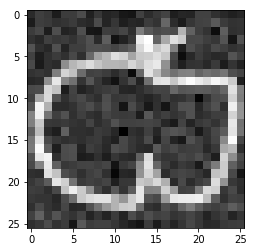

In [100]:
plt.imshow(gausian_images[2])
plt.set_cmap("gray")

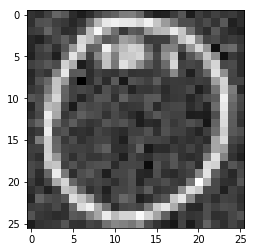

In [101]:
plt.imshow(gausian_images[3])
plt.set_cmap("gray")

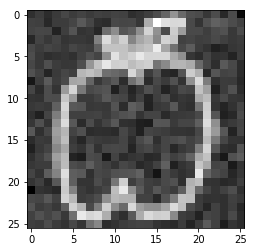

In [102]:
plt.imshow(gausian_images[4])
plt.set_cmap("gray")

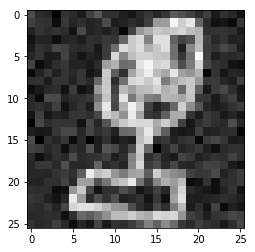

In [103]:
plt.imshow(gausian_images[5])
plt.set_cmap("gray")

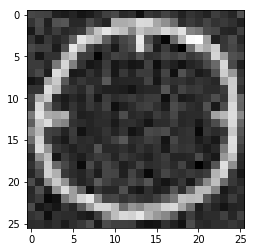

In [104]:
plt.imshow(gausian_images[6])
plt.set_cmap("gray")

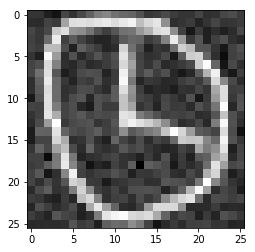

In [105]:
plt.imshow(gausian_images[7])
plt.set_cmap("gray")

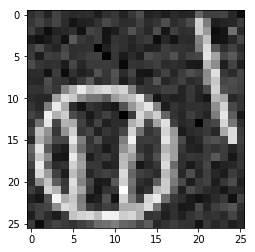

In [106]:
plt.imshow(gausian_images[8])
plt.set_cmap("gray")

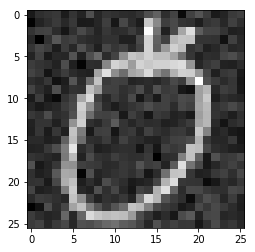

In [107]:
plt.imshow(gausian_images[9])
plt.set_cmap("gray")

In [109]:
test_vall=np.zeros((10,676))
for i in range(0, 10):
    test_vall[i] = gausian_images[i].flatten()
test_vall = (test_vall - MEAN)/STD
print(torch.max(model(torch.from_numpy(test_vall).float()), 1)[1].numpy())

[1 0 0 3 0 4 3 3 1 0]


In [110]:
horz_images = np.zeros((10,26,26)) 
for index in range(0, 10):
    for i in range(0, 26):
        for j in range(0,13):
            horz_images[index][i][j] = torch_images[index][i][25-j]
        for k in range(0,13):
            horz_images[index][i][k+13] = torch_images[index][i][12-k]

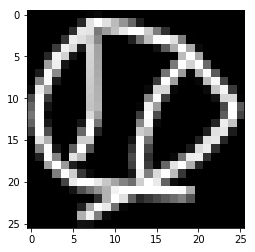

In [111]:
plt.imshow(horz_images[0])
plt.set_cmap("gray")

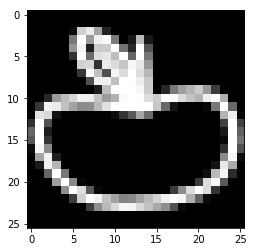

In [112]:
plt.imshow(horz_images[1])
plt.set_cmap("gray")

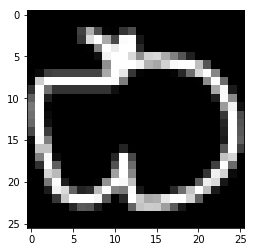

In [113]:
plt.imshow(horz_images[2])
plt.set_cmap("gray")

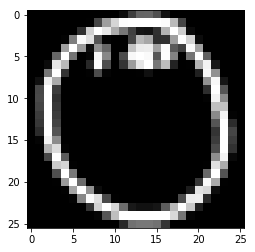

In [114]:
plt.imshow(horz_images[3])
plt.set_cmap("gray")

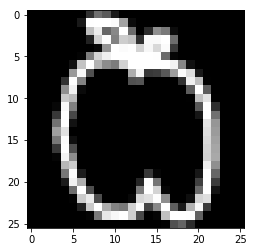

In [115]:
plt.imshow(horz_images[4])
plt.set_cmap("gray")

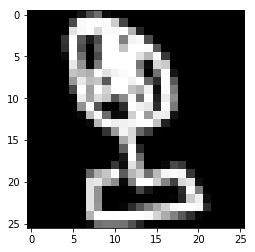

In [116]:
plt.imshow(horz_images[5])
plt.set_cmap("gray")

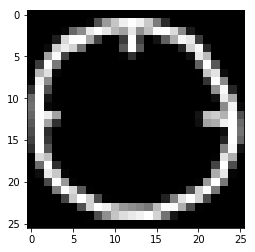

In [117]:
plt.imshow(horz_images[6])
plt.set_cmap("gray")

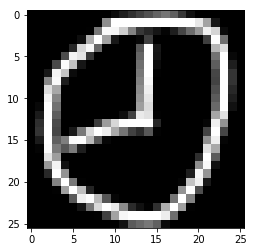

In [118]:
plt.imshow(horz_images[7])
plt.set_cmap("gray")

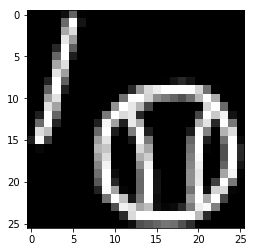

In [119]:
plt.imshow(horz_images[8])
plt.set_cmap("gray")

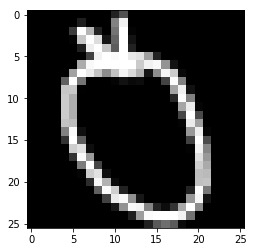

In [120]:
plt.imshow(horz_images[9])
plt.set_cmap("gray")

In [121]:
test_vall=np.zeros((10,676))
for i in range(0, 10):
    test_vall[i] = horz_images[i].flatten()
test_vall = (test_vall - MEAN)/STD
print(torch.max(model(torch.from_numpy(test_vall).float()), 1)[1].numpy())

[1 0 0 3 0 4 3 3 1 0]
